# Exercise 4: Machine Learning Methods

In this exercise, we will experiment with Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from tqdm import tqdm
# Add current directory to path to import helpers if needed
sys.path.append(os.getcwd())
try:
    from helpers import *
except ImportError:
    print("helpers.py not found or error importing")

## 2. Seeding

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(42)

# 5. Data
## 5.1 European Countries
The dataset consists of train.csv, validation.csv, test.csv. 
Columns: longitude (long), latitude (lat), country (label).

The dataset used for our exploration consists of three distinct files: train.csv,
validation.csv, test.csv. Each file is structured as a table, with three columns:
longitude (long), latitude (lat) and country.   
The samples in our dataset are represented as 2D coordinates of cities in Europe from different countries, with the corresponding labels indicating the country. For instance, if we consider a 2D city coordinate such as (48.866667, 2.333333) – representative of Paris – its label would be ’France’. To make it easier, we already encoded the country column into integers.


We will use this spatial dataset for exploring MLPs, by classifying the cities into countries based on their geographical coordinates.


In [3]:
class EuropeDataset(Dataset):
    def __init__(self, split='train'):
        filename = f"{split}.csv"
        if not os.path.exists(filename):
            print(f"Warning: {filename} not found. Make sure you are in the correct directory.")
            self.X = torch.empty(0, 2)
            self.y = torch.empty(0, dtype=torch.long)
            return
            
        self.data = pd.read_csv(filename)
        # Features: long, lat
        self.X = torch.tensor(self.data[['long', 'lat']].values, dtype=torch.float32)
        # Labels: country
        self.y = torch.tensor(self.data['country'].values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
ds = EuropeDataset('train')
len(ds), ds[0]

(106897, (tensor([20.1446, 51.2168]), tensor(24)))

# helpers

### plotting

In [5]:
def plot_lines(data, xlabel='X', ylabel='Y', title='', figsize=(10, 6), 
              legend_loc='best', grid=True, x_shared=None):
   """
   Flexible line plotting for experiments.
   
   Args:
       data: dict of {label: y_values} or {label: (x_values, y_values)}
       x_shared: optional shared x-axis values if data contains only y values
       xlabel, ylabel, title: plot labels
   
   Examples:
       # Multiple curves with shared x
       plot_lines({'LR=0.01': [loss1, loss2, ...], 'LR=0.001': [...]}, 
                  x_shared=range(50), xlabel='Epoch', ylabel='Loss')
       
       # Multiple curves with custom x per curve
       plot_lines({'Train': (epochs, train_loss), 'Val': (epochs, val_loss)})
   """
   plt.figure(figsize=figsize)

   for label, values in data.items():
       if isinstance(values, tuple):
           x, y = values
           plt.plot(x, y, label=label, marker='o', markersize=3)
       else:
           x = x_shared if x_shared is not None else range(len(values))
           plt.plot(x, values, label=label, marker='o', markersize=3)

   plt.xlabel(xlabel, fontsize=12)
   plt.ylabel(ylabel, fontsize=12)
   plt.title(title, fontsize=14, fontweight='bold')
   plt.legend(loc=legend_loc)
   if grid:
       plt.grid(alpha=0.3)
   plt.tight_layout()
   plt.show()


def plot_bar_comparison(x_values, y_data, xlabel='X', ylabel='Y', title='', 
                       figsize=(10, 6), legend_loc='best'):
   """
   Bar plot comparison for metrics across configurations.
   
   Args:
       x_values: list of x-axis labels (e.g., [1, 2, 6, 10] for depths)
       y_data: dict of {metric_name: [values]} (e.g., {'train_acc': [...], 'val_acc': [...]})
   
   Example:
       plot_bar_comparison([1, 2, 6, 10], 
                          {'Train': [0.8, 0.85, 0.9, 0.88], 'Val': [0.75, 0.8, 0.85, 0.82]},
                          xlabel='Depth', ylabel='Accuracy')
   """
   plt.figure(figsize=figsize)

   x_pos = np.arange(len(x_values))
   width = 0.8 / len(y_data)

   for i, (label, values) in enumerate(y_data.items()):
       offset = width * i - (width * len(y_data) / 2 - width / 2)
       plt.bar(x_pos + offset, values, width, label=label, alpha=0.8)

   plt.xlabel(xlabel, fontsize=12)
   plt.ylabel(ylabel, fontsize=12)
   plt.title(title, fontsize=14, fontweight='bold')
   plt.xticks(x_pos, x_values)
   plt.legend(loc=legend_loc)
   plt.grid(axis='y', alpha=0.3)
   plt.tight_layout()
   plt.show()


def plot_multi_metric(x_values, y_data, xlabel='X', ylabel='Y', title='',
                     figsize=(10, 6), legend_loc='best', markers=True):
   """
   Line plot with multiple metrics (similar to plot_lines but with x_values).
   
   Args:
       x_values: shared x-axis values
       y_data: dict of {metric_name: [values]}
   
   Example:
       plot_multi_metric([1, 2, 6, 10],
                        {'Train': [0.8, 0.85, 0.9, 0.88], 'Val': [0.75, 0.8, 0.85, 0.82]},
                        xlabel='Depth', ylabel='Accuracy')
   """
   plt.figure(figsize=figsize)

   for label, values in y_data.items():
       if markers:
           plt.plot(x_values, values, label=label, marker='o', markersize=8, linewidth=2)
       else:
           plt.plot(x_values, values, label=label, linewidth=2)

   plt.xlabel(xlabel, fontsize=12)
   plt.ylabel(ylabel, fontsize=12)
   plt.title(title, fontsize=14, fontweight='bold')
   plt.legend(loc=legend_loc)
   plt.grid(alpha=0.3)
   plt.tight_layout()
   plt.show()




# 6. Multi-Layer Perceptrons
## 6.1 Optimization of an MLP
### 6.1.1 Task
Implement a training pipeline from scratch. 
Model: 6 layers (includes input but not output -> 7 nn.Linear instances). Activation: ReLU. Batch Norm before activation.
Default parameters provided in code.

In [9]:
class MLP(nn.Module):
    def __init__(self, input_dim=2, output_dim=5, hidden_dim=16, num_layers=6, use_batch_norm=False):
        super(MLP, self).__init__()
        layers = []
        

        
        dims = [input_dim] + [hidden_dim] * num_layers + [output_dim]
        
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            # Add activation and BN for all but the last layer
            if i < len(dims) - 2:
                if use_batch_norm:
                    layers.append(nn.BatchNorm1d(dims[i+1]))
                layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [42]:
class MLPTrainer:
    def __init__(self, 
                 learning_rate=1e-3, 
                 num_epochs=50, 
                 batch_size=256, 
                 use_batch_norm=False,
                 hidden_dim=16,
                 num_layers=6,
                 seed=42,
                 grad_monitor_layers=None): # New argument
        
        set_seed(seed)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Data
        self.train_ds = EuropeDataset('train')
        self.val_ds = EuropeDataset('validation')
        self.test_ds = EuropeDataset('test')
        
        self.batch_size = batch_size
        self.train_loader = DataLoader(self.train_ds, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_ds, batch_size=batch_size, shuffle=False)
        self.test_loader = DataLoader(self.test_ds, batch_size=batch_size, shuffle=False)
        
        # Model
        output_dim = len(torch.unique(self.train_ds.y))
        self.model = MLP(input_dim=2, output_dim=output_dim, 
                         hidden_dim=hidden_dim, num_layers=num_layers, 
                         use_batch_norm=use_batch_norm).to(self.device)
        
        # Optimization
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)
        
        self.num_epochs = num_epochs
        
        # History
        self.history = {
            'train_loss': [], 'val_loss': [], 'test_loss': [],
            'train_acc': [], 'val_acc': [], 'test_acc': [],
            'batch_losses': [], 
            'grad_norms': {} # New storage for gradient norms
        }

        # Gradient Monitoring Setup
        self.grad_monitor_layers = grad_monitor_layers
        self.monitored_linear_layers = {}
        
        if self.grad_monitor_layers is not None:
            # Initialize history lists for requested layers
            for layer_idx in self.grad_monitor_layers:
                self.history['grad_norms'][layer_idx] = []
            
            # Extract only the Linear layers from the sequential model
            all_linear_layers = [m for m in self.model.model if isinstance(m, nn.Linear)]
            
            # Map requested indices to actual layer objects
            for idx in self.grad_monitor_layers:
                if 0 <= idx < len(all_linear_layers):
                    self.monitored_linear_layers[idx] = all_linear_layers[idx]
                else:
                    print(f"Warning: Gradient monitor requested layer {idx}, but model only has {len(all_linear_layers)} linear layers.")

    def _maybe_update_grad_history(self, epoch_grad_accumulators):
        """
        Calculates ||grad||^2_2 for monitored layers and adds to epoch accumulator.
        """
        if not self.grad_monitor_layers:
            return

        for idx, layer in self.monitored_linear_layers.items():
            # We monitor the weight gradients.
            if layer.weight.grad is not None:
                # norm(2) is L2 norm. Square it as per instructions.
                grad_mag = layer.weight.grad.norm(2).item() ** 2
                epoch_grad_accumulators[idx] += grad_mag

    def train(self):
        # print(f"Starting training on {self.device}...")
        for epoch in tqdm(range(self.num_epochs), desc="Epochs", leave=False):
            self.model.train()
            train_loss = 0.0
            correct = 0
            total = 0
            
            # Reset gradient accumulators for this epoch
            # Dict mapping layer_idx -> cumulative sum of mags for this epoch
            epoch_grad_accumulators = {idx: 0.0 for idx in self.grad_monitor_layers} if self.grad_monitor_layers else None
            num_batches = 0
            
            for X, y in self.train_loader:
                X, y = X.to(self.device), y.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(X)
                loss = self.criterion(outputs, y)
                loss.backward()
                
                # --- Gradient Monitoring Hook ---
                if self.grad_monitor_layers:
                    self._maybe_update_grad_history(epoch_grad_accumulators)
                    num_batches += 1
                # --------------------------------
                
                self.optimizer.step()
                
                # Standard Metrics
                batch_loss = loss.item()
                self.history['batch_losses'].append(batch_loss)
                train_loss += batch_loss * X.size(0)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
            
            # End of Epoch: Average Gradients and Store
            if self.grad_monitor_layers and num_batches > 0:
                for idx in self.grad_monitor_layers:
                    avg_mag = epoch_grad_accumulators[idx] / num_batches
                    self.history['grad_norms'][idx].append(avg_mag)

            # Epoch Averages
            avg_train_loss = train_loss / total
            train_acc = correct / total
            
            # Evaluations
            val_loss, val_acc = self.evaluate(self.val_loader)
            test_loss, test_acc = self.evaluate(self.test_loader)
            
            # Update History
            self.history['train_loss'].append(avg_train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)
            
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(self.device), y.to(self.device)
                outputs = self.model(X)
                loss = self.criterion(outputs, y)
                total_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
        
        if total == 0: return 0.0, 0.0
        return total_loss / total, correct / total

### batchnorm

 Deep Dive: Understanding BatchNorm

BatchNorm is a crucial normalization technique that helps with training stability and speed. Let's understand it deeply:

**The Equation**
For input $x$ with shape $(N, C)$ where $N$ is batch size and $C$ is number of features:

$$y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x] + \epsilon}} \cdot \gamma + \beta$$

Where:
- $\mathbb{E}[x]$ and $\text{Var}[x]$ are computed **per-feature across the batch** (mean/var over the $N$ dimension)
- $\epsilon$ is a small constant for numerical stability (default: 1e-5)
- $\gamma$ and $\beta$ are **learnable** scale and shift parameters (one per feature)

**Key Principle**
BatchNorm **normalizes each feature independently** by computing statistics across the batch dimension. This:
1. **Reduces internal covariate shift** - keeps activations stable as network learns
2. **Allows higher learning rates** - less sensitive to initialization
3. **Acts as regularization** - adds noise through batch statistics

how it works:
1. center: **in training**, center each feature with stats of batch + update EMA of global mean and ar to get an estiamte of the overall mean and var of data. **in evall**, center the data *as though* its mean and var were the global ones. 
2. scale each feature with learnt param gamma and beta. 

### 6.1.2 Questions
1. **Learning Rate**: Train with 1, 0.01, 0.001, 0.00001. Plot validation loss.
2. **Epochs**: Train for 100 epochs. Plot loss.
3. **Batch Norm**: Add batch norm. Compare.
4. **Batch Size**: 1, 16, 128, 1024.

#### 6.1.2.1 Learning rates

#### class

In [59]:
class Q_1:
    """
    Handles the experimentation for Question 6.1.2.1: Learning Rate.
    Trains multiple MLPs with different learning rates and plots the validation loss.
    """
    def __init__(self, learning_rates=None, num_epochs=50):
        # Default LRs based on your snippet
        if learning_rates is None:
            self.learning_rates = [1.0, 0.2, 0.01, 0.001, 5e-4, 0.00001]
        else:
            self.learning_rates = learning_rates
            
        self.num_epochs = num_epochs
        self.results = {}  # Dictionary to store history for plotting

    def run_experiment(self):
        print(f"--- Starting Q1 Experiment: Learning Rates {self.learning_rates} ---")
        
        for lr in self.learning_rates:
            print(f"Training with LR={lr}...")
            
            # (i) & (ii) Seeding as requested in Section 2
            set_seed(42)
            
            # Initialize Trainer with Q1 specific parameters
            trainer = MLPTrainer(
                learning_rate=lr, 
                num_epochs=self.num_epochs, 
                hidden_dim=16, 
                num_layers=6
            )
            
            trainer.train()
            
            # Store validation loss for the plot
            self.results[f'LR={lr}'] = trainer.history['val_loss']
            print(f"  -> Final val loss: {trainer.history['val_loss'][-1]:.4f}")

        # Plot the aggregated results
        self._plot_results()

    def _plot_results(self):
        print("Plotting results...")
        plot_lines(
            self.results, 
            x_shared=range(1, self.num_epochs + 1),
            xlabel='Epoch', 
            ylabel='Validation Loss', 
            title='Q1: Effect of Learning Rate on Validation Loss',
            figsize=(12, 6)
        )

#### discussion

--- Starting Q1 Experiment: Learning Rates [1.0, 0.2, 0.01, 0.001, 0.0005, 1e-05] ---
Training with LR=1.0...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.33it/s]


  -> Final val loss: 3.2565
Training with LR=0.2...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.33it/s]


  -> Final val loss: 3.2560
Training with LR=0.01...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.32it/s]


  -> Final val loss: 1.4709
Training with LR=0.001...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.32it/s]


  -> Final val loss: 2.0880
Training with LR=0.0005...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.32it/s]


  -> Final val loss: 2.6761
Training with LR=1e-05...


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:37<00:00,  1.33it/s]

  -> Final val loss: 3.4827
Plotting results...


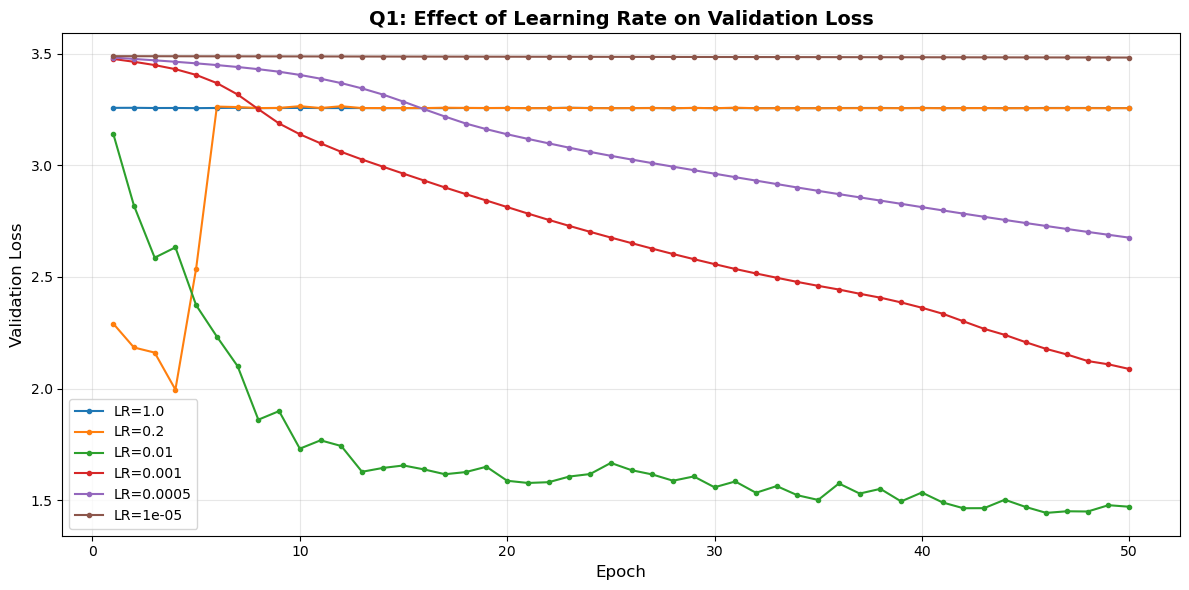

In [60]:
# Usage
q1 = Q_1()
q1.run_experiment()

we analyse the smoothness, slope and trend of each plot. 
we start with the 'sucessful' cases where the loss meaningfully decreased. 
for a learning rate of `1e-3` we see a very smooth plot suggesting a stable improvment from epoch to epoch, with no overshooting of the 'correct' direction in the loss landscape. the fact that the plot has a constant slope, suggests trianing could have go on for longer. with a lr of `1e-2` we see that the loss decreases shaply, meaning the model was able to take large steps in the overall correct direction, but near the end began to overshot in some directions. this is the reason many training schedules decrease the lr near the end, when smaller steps are needed. we note this is the only slope that seemed to saturate, suggesting we are not far from the global minimum. 

the plot for `1e-5` and `1.0` were both stuck at a constant value.
intuitively, we say that a lr of `1.0` is too large, but we need the plot for `0.2` to correctly diagnose it: we see that with a large lr, there is a change in the val loss in the first few epochs but then it flatlines. we suspect that this is a case where all the neurons are 'dead', and the relu's are outputting only 0, preventing the model from improving.
in contrast, the 1e-5 plot is at a differnet constant value, and we suspect this is the original val loss by the random initalisation, and dmeonstarates that the lr is too small (we scale the grads by the lr). 

#### 6.1.2.2 epochs

#### class

In [11]:
class Q2_Experiment:
    """
    Handles the configuration and execution of Question 6.1.2.2.
    """
    def __init__(self, num_epochs=100, use_batch_norm=False, seed = 42, kaiming_init = False):
        self.num_epochs = num_epochs
        self.trainer = None # Placeholder for the MLPTrainer instance
        self.is_trained = False
        self.use_batch_norm = use_batch_norm
        self.seed = seed
        self.kaiming_init = kaiming_init

    def run(self):
        print(f"--- Starting Experiment: {self.num_epochs} Epochs ---")
        
        # Initialize the generic MLPTrainer
        self.trainer = MLPTrainer(
            learning_rate=1e-3,
            num_epochs=self.num_epochs,
            hidden_dim=16,
            num_layers=6,
            seed=self.seed,
            use_batch_norm=self.use_batch_norm,
            kaiming_init=self.kaiming_init
        )
        
        # Execute training
        self.trainer.train()
        self.is_trained = True
        print("Training complete.")

    def get_history(self):
        if not self.is_trained:
            raise ValueError("Model has not been trained yet. Call .run() first.")
        return self.trainer.history


class Q2_Results:
    """
    Handles the visualization and analysis for Question 6.1.2.2.
    Takes a Q2_Experiment instance as input.
    """
    def __init__(self, experiment):
        self.experiment = experiment
        
    def plot(self):
        # 1. robust check
        if not self.experiment.is_trained:
            print("Warning: Experiment not run yet. Nothing to plot.")
            return

        # 2. Extract Data
        history = self.experiment.get_history()
        epochs_range = range(1, self.experiment.num_epochs + 1)
        
        # 3. Create Subplots (1 Row, 2 Columns)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # --- Plot 1: Loss (Left) ---
        ax1.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', markersize=3)
        ax1.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o', markersize=3)
        ax1.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o', markersize=3)
        
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Loss over Epochs', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # --- Plot 2: Accuracy (Right) ---
        ax2.plot(epochs_range, history['train_acc'], label='Train Acc', marker='o', markersize=3)
        ax2.plot(epochs_range, history['val_acc'], label='Val Acc', marker='o', markersize=3)
        ax2.plot(epochs_range, history['test_acc'], label='Test Acc', marker='o', markersize=3)
        
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Accuracy over Epochs', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)

        # Final Layout Adjustments
        plt.tight_layout()
        plt.show()

#### discussion

--- Starting Experiment: 100 Epochs ---


Training complete.


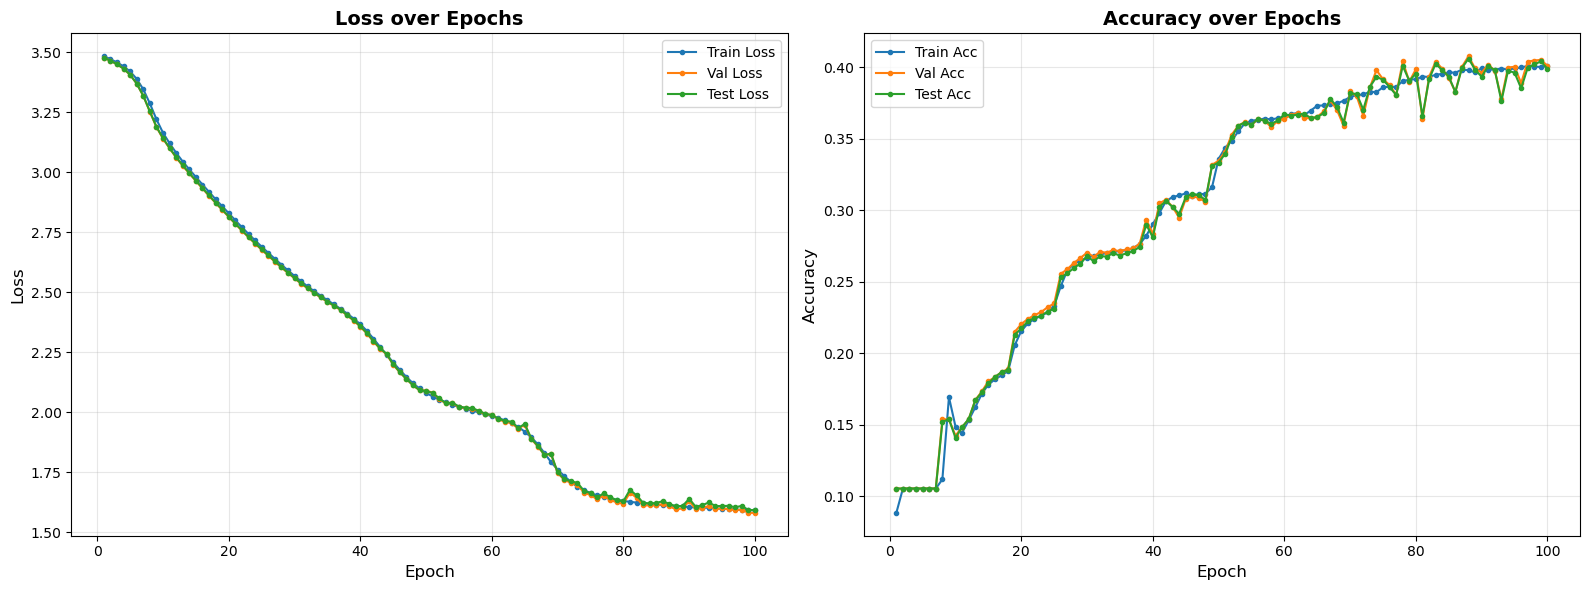

In [12]:
# Instantiate and run
q2_exp = Q2_Experiment(num_epochs=100)
q2_exp.run()
#Access the trainer later: q2.trainers['epochs_100'].model ...

q2_res = Q2_Results(q2_exp)

# If you change the plot style in Q2_Results, just re-run this cell
q2_res.plot()

as indicated in question 1, with a lr of 1e-3 we have stable training, evne up to 100 epochs. the train, test and val loss  / accuracy stay in line, indicating we aren't suffering from overfitting, although the val and test acc became less stable towards the end of trianing, even as the loss remained stable, indicating the model was stochastically changing its predicitons on a subset of the data. we suspect that if we had measured AUROC, we would have had a more stable metric, since if a subset of samples with borderline logits keep getting a different class, the accuracy will change, but the AUROC would remain stable. 

#### 6.1.2.3

#### discussion

In [70]:
# Instantiate and run
q3_exp = Q2_Experiment(num_epochs=100,use_batch_norm = True)
q3_exp.run()
#Access the trainer later: q2.trainers['epochs_100'].model ...

--- Starting Q2 Experiment: 100 Epochs ---


Training complete.


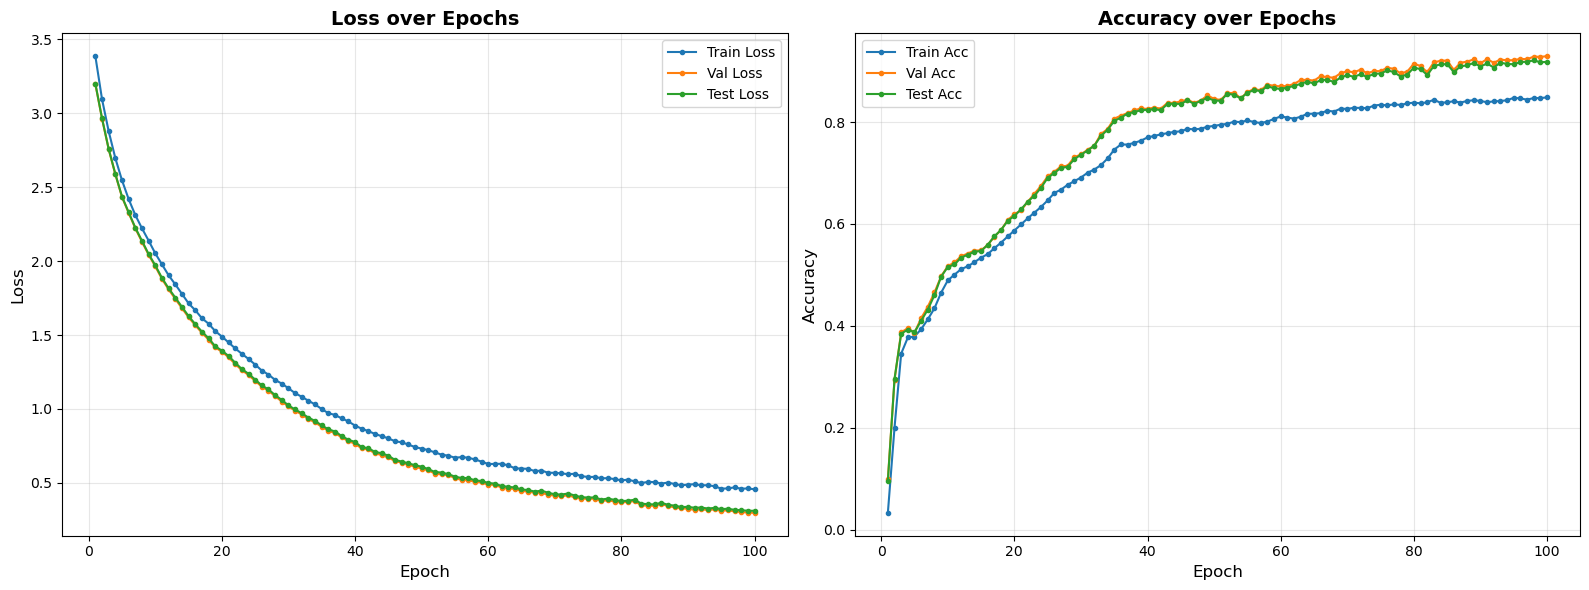

In [73]:
q3_res = Q2_Results(q3_exp)
q3_res.plot()

we see substantially better performance with batch norm:
the final loss goes down to 0.5 vs 1.5 and the **accuracy doubles** to 80%!
the batch norm paper (https://arxiv.org/abs/1502.03167) points to a few benefits of batch norm that could explian this:
1. preventing 'internal covariate shift' -> the input to every layer is centered, giving the model an easier target to adapt to.
2.  more importantly, since the input is centered, there can never be a case where the entire input to a relu is negative ('dead neuron'), menaing the network is probably using more of its weights.

we note the that the test and val performance is superior to the training performance. this is probably explianed by the fact that in eval, the model centers the data relative to the entire trianing data (via the EMA), meaning that it has a stronger inductive bias. during training, if a mini batch happens to have several similar samples, the model throws out some information since it centers them relative to each other.


#### 6.1.2.4 

#### class

In [3]:
class Q4_Experiment:
    """
    Handles the configuration and execution of Question 6.1.2.4 (Batch Size).
    Configurations:
      - BS 1    -> 1 Epoch
      - BS 16   -> 10 Epochs
      - BS 128  -> 50 Epochs
      - BS 1024 -> 50 Epochs
    """
    def __init__(self, seed=42):
        self.seed = seed
        self.configs = [
            {'bs': 1,    'epochs': 1},
            {'bs': 16,   'epochs': 10},
            {'bs': 128,  'epochs': 50},
            {'bs': 1024, 'epochs': 50}
        ]
        self.results = {}
        self.is_trained = False
        self.lr = lr

    def run(self):
        print(f"--- Starting Experiment: Batch Size Analysis ---")
        
        for config in self.configs:
            bs = config['bs']
            epochs = config['epochs']
            print(f"Running: Batch Size = {bs}, Epochs = {epochs}")
            
            # Initialize Trainer
            trainer = MLPTrainer(
                learning_rate=1e-3, # Default from Ex 6.1.1
                num_epochs=epochs,
                batch_size=bs,
                hidden_dim=16,
                num_layers=6,
                seed=self.seed,
                use_batch_norm=False 
            )
            
            # Train
            trainer.train()
            
            # Store necessary data
            # We calculate iterations per epoch using the loader length
            iters_per_epoch = len(trainer.train_loader)
            
            self.results[bs] = {
                'history': trainer.history,
                'iters_per_epoch': iters_per_epoch,
                'epochs': epochs
            }
            
        self.is_trained = True
        print("All configurations complete.")

    def get_results(self):
        if not self.is_trained:
            raise ValueError("Experiment not run yet.")
        return self.results


class Q4_Results:
    """
    Handles visualization and analysis for Question 6.1.2.4.
    """
    def __init__(self, experiment):
        self.experiment = experiment
        
    def plot(self):
        if not self.experiment.is_trained:
            print("Warning: Experiment not run yet.")
            return

        results = self.experiment.get_results()
        
        # --- Part (ii) Speed (Text Output) ---
        print("\n=== (ii) Speed Analysis: Iterations per Epoch ===")
        print(f"{'Batch Size':<12} | {'Iterations/Epoch':<20}")
        print("-" * 35)
        for bs, data in results.items():
            print(f"{bs:<12} | {data['iters_per_epoch']:<20}")
        print("-" * 35)
        print("\n")

        # Create Layout: 2 Plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        # --- Part (i) Accuracy (Val) vs Epoch ---
        for bs, data in results.items():
            history = data['history']
            epochs = range(1, data['epochs'] + 1)
            ax1.plot(epochs, history['val_acc'], label=f'BS={bs}', marker='o', markersize=4)

        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Validation Accuracy', fontsize=12)
        ax1.set_title('(i) Validation Accuracy vs. Epoch', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(alpha=0.3)

        # --- Part (iii) Stability: Training Loss vs Batch ---
        # Note: BS=1 creates massive amount of points, we use thinner lines/alpha
        for bs, data in results.items():
            batch_losses = data['history']['batch_losses']
            # X-axis is simply the cumulative batch step count
            steps = range(len(batch_losses))
            
            # Aesthetics adjustments for visibility
            alpha = 0.6 if bs > 1 else 0.3 # Make BS=1 more transparent as it's very noisy
            linewidth = 1.5 if bs > 1 else 0.5
            
            ax2.plot(steps, batch_losses, label=f'BS={bs}', 
                     alpha=alpha, linewidth=linewidth)

        ax2.set_xlabel('Cumulative Batch Iterations', fontsize=12)
        ax2.set_ylabel('Training Loss', fontsize=12)
        ax2.set_title('(iii) Stability: Training Loss vs. Batch', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # Optional: Log scale for x-axis on stability plot might help visualize 
        # the short BS=1024 runs vs long BS=1 runs, but linear is usually expected 
        # to show the "noise" pattern clearly.
        
        plt.tight_layout()
        plt.show()

#### discussion

--- Starting Experiment: Batch Size Analysis ---
Running: Batch Size = 1, Epochs = 1


Running: Batch Size = 16, Epochs = 10


Running: Batch Size = 128, Epochs = 50


Running: Batch Size = 1024, Epochs = 50


All configurations complete.

=== (ii) Speed Analysis: Iterations per Epoch ===
Batch Size   | Iterations/Epoch    
-----------------------------------
1            | 106897              
16           | 6682                
128          | 836                 
1024         | 105                 
-----------------------------------




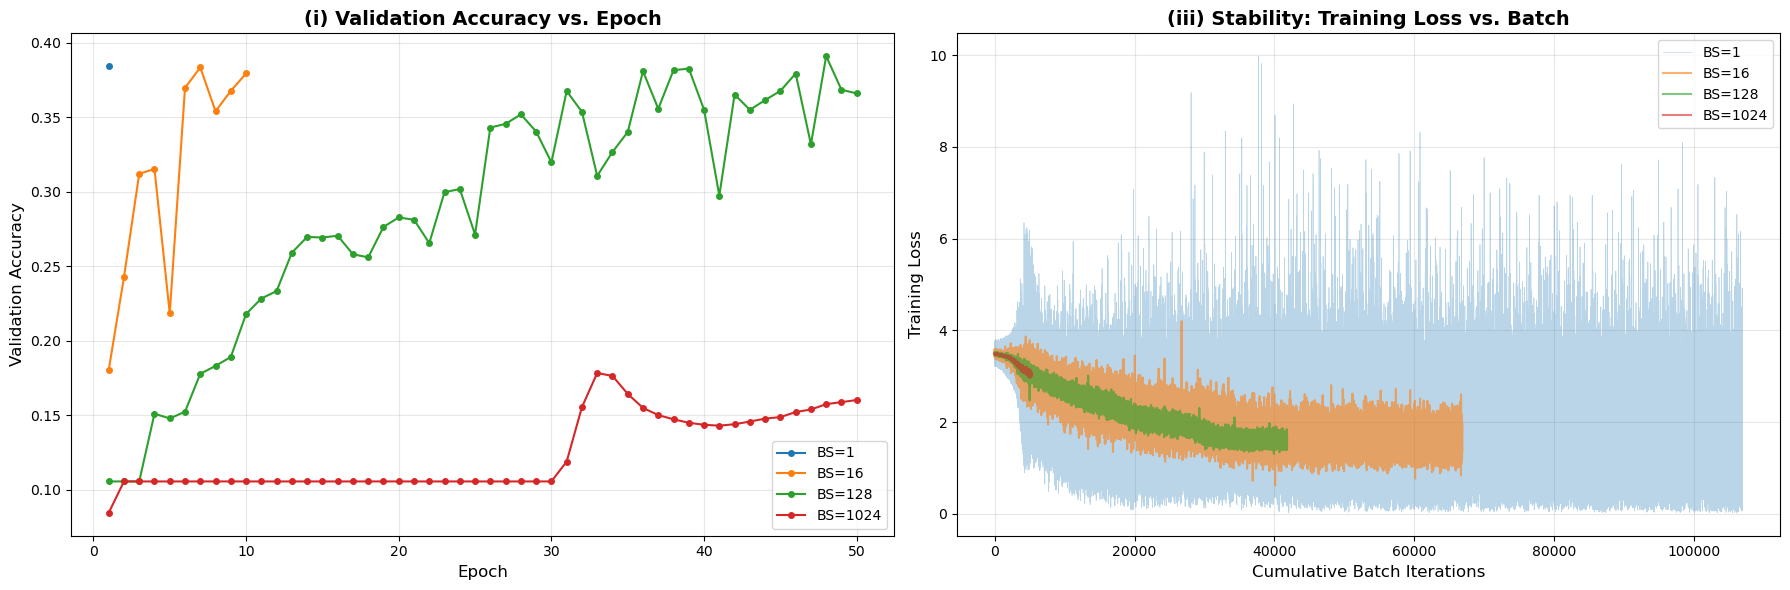

In [79]:
# 1. Run the experiment
q4_exp = Q4_Experiment(seed=42)
q4_exp.run()

# 2. Visualize results
q4_res = Q4_Results(q4_exp)
q4_res.plot()

in this analysis we hold the lr constant, and adjust only the batch size. an immediate result is that the differnet configurations have vastly different numbers of learning steps: the first model took 100k steps, while the last (batch size 1024) took `50 * 105 = 5000`, a 20 fold differnce.
in general, the larger the bacth size the more 'trustworthy' the gradiants at a particualr step.
we can see that the larger the batch size, the more stable (smaller varinace) the loss. b
we see that for the batch size 16 and 128, the model acheives the 'max' accuracy of around 40% after at least 40_000 steps. we saw the smae thing in questions 2 and 3, where wew used the same lr but a batch size of 256: we trained for 100 epochs, giving a total of ~40k steps. 
the corollary of this experiment would be to use a larger learning rate for the larger batch sizes. 

# 6.2 evaluating MLPs

### training classes

In [21]:
class Q6_2_Experiment:
    """
    Handles the configuration and execution of Section 6.2: Evaluating MLPs Performance.
    Trains 6 classifiers with specific Depth/Width combinations.
    """
    def __init__(self, epochs=50, learning_rate=1e-3, batch_size=128, seed=42):
        self.epochs = epochs
        self.lr = learning_rate
        self.batch_size = batch_size
        self.seed = seed
        self.is_trained = False
        
        # Configuration from Table 2
        # Note: We group them by logic for easier debugging/tracking
        self.configs = [
            # Varying Depth (Width fixed at 16)
            {'depth': 1, 'width': 16},
            {'depth': 2, 'width': 16},
            {'depth': 6, 'width': 16},
            {'depth': 10, 'width': 16},
            
            # Varying Width (Depth fixed at 6)
            # Note: Depth 6 / Width 16 is already in the list above, 
            # we won't train it twice, just reference it.
            {'depth': 6, 'width': 8},
            {'depth': 6, 'width': 32},
            {'depth': 6, 'width': 64},
        ]
        
        # Dictionary to store trainer instances: key = "d{depth}_w{width}"
        self.trainers = {} 

    def get_key(self, depth, width):
        return f"d{depth}_w{width}"

    def run(self):
        print(f"--- Starting Section 6.2 Experiment ({len(self.configs)} configurations) ---")
        
        for config in self.configs:
            depth = config['depth']
            width = config['width']
            key = self.get_key(depth, width)
            
            # Avoid retraining if duplicate config exists (d6_w16 appears in both logic sets)
            if key in self.trainers:
                continue
            
            print(f"Training MLP | Depth: {depth} | Width: {width}...")
            
            trainer = MLPTrainer(
                learning_rate=self.lr,
                num_epochs=self.epochs,
                batch_size=self.batch_size,
                hidden_dim=width,
                num_layers=depth,
                use_batch_norm=True, # Standard MLP per instructions unless BN specified
                seed=self.seed
            )
            
            trainer.train()
            self.trainers[key] = trainer
            
        self.is_trained = True
        print("All configurations trained.")

    def get_results_by_depth(self, fixed_width=16):
        """Returns list of (depth, trainer) sorted by depth for Q6.2.3"""
        filtered = []
        for key, trainer in self.trainers.items():
            # Extract config from key or trainer attributes
            # trainer.model is wrapped, but we can infer from key or store config in trainer
            # Let's parse the key "dX_wY"
            d_str, w_str = key.split('_')
            d = int(d_str[1:])
            w = int(w_str[1:])
            
            if w == fixed_width:
                filtered.append((d, trainer))
        
        # Sort by depth
        filtered.sort(key=lambda x: x[0])
        return filtered

    def get_results_by_width(self, fixed_depth=6):
        """Returns list of (width, trainer) sorted by width for Q6.2.4"""
        filtered = []
        for key, trainer in self.trainers.items():
            d_str, w_str = key.split('_')
            d = int(d_str[1:])
            w = int(w_str[1:])
            
            if d == fixed_depth:
                filtered.append((w, trainer))
        
        # Sort by width
        filtered.sort(key=lambda x: x[0])
        return filtered

    def get_ranked_models(self):
        """
        Returns a list of (key, trainer, val_acc) sorted by validation accuracy (descending).
        Used for Q6.2.1 and Q6.2.2 (Best/Worst models).
        """
        ranking = []
        for key, trainer in self.trainers.items():
            # Get final validation accuracy
            final_val_acc = trainer.history['val_acc'][-1]
            ranking.append((key, trainer, final_val_acc))
        
        # Sort descending
        ranking.sort(key=lambda x: x[2], reverse=True)
        return ranking

In [26]:
class Q6_2_5_Experiment:
    """
    Handles Question 6.2.5: Monitoring Gradients in a Deep MLP.
    """
    def __init__(self, epochs=10, seed=42):
        self.epochs = epochs
        self.seed = seed
        self.trainer = None
        self.is_trained = False
        
        # Specific Architecture per Q6.2.5
        self.hidden_dim = 4
        self.num_layers = 100 # 100 hidden layers
        
        # Layers to monitor (0-based index of Linear layers)
        self.layers_to_monitor = [0, 30, 60, 90, 95, 99]

    def run(self):
        print(f"--- Starting Gradient Monitoring Experiment (Depth: {self.num_layers}) ---")
        
        self.trainer = MLPTrainer(
            learning_rate=1e-3, # Default used in other exp, adjustable if needed
            num_epochs=self.epochs,
            batch_size=256,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            use_batch_norm=False,
            seed=self.seed,
            grad_monitor_layers=self.layers_to_monitor
        )
        
        self.trainer.train()
        self.is_trained = True
        print("Training complete.")

class Q6_2_5_Results:
    """
    Visualization for Gradient Monitoring.
    """
    def __init__(self, experiment):
        self.experiment = experiment

    def plot(self):
        if not self.experiment.is_trained:
            print("Warning: Experiment not run yet.")
            return

        history = self.experiment.trainer.history['grad_norms']
        epochs = range(1, self.experiment.epochs + 1)
        
        plt.figure(figsize=(10, 6))
        
        for layer_idx, grads in history.items():
            plt.plot(epochs, grads, label=f'Layer {layer_idx}', marker='o', markersize=4)

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Mean Gradient Magnitude ($||g||^2$)', fontsize=12)
        plt.title(f'Gradient Magnitude per Layer (Depth {self.experiment.num_layers})', 
                  fontsize=14, fontweight='bold')
        
        # Log scale is often useful here as gradients can differ by orders of magnitude
        # but let's stick to linear first or check range. 
        # Usually vanishing gradients means values near 0, exploding means huge.
        plt.yscale('log') 
        plt.legend()
        plt.grid(True, which="both", ls="-", alpha=0.3)
        plt.tight_layout()
        plt.show()

In [17]:
class Q6_2_Results:
    """
    Handles the visualization and analysis for Question 6.2.
    """
    def __init__(self, experiment):
        self.experiment = experiment

    def _plot_model_performance(self, rank_index, label_type):
        """Helper for Q1/Q2 (Best/Worst models)"""
        if not self.experiment.is_trained:
            print("Warning: Experiment not run yet.")
            return

        ranked_models = self.experiment.get_ranked_models()
        key, trainer, acc = ranked_models[rank_index]
        
        print(f"--- Analysis of {label_type} Model ---")
        print(f"Configuration: {key}")
        print(f"Final Validation Accuracy: {acc:.4f}")

        # Plot Losses
        history = trainer.history
        epochs_range = range(1, len(history['train_loss']) + 1)
        
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', markersize=3)
        plt.plot(epochs_range, history['val_loss'], label='Val Loss', marker='o', markersize=3)
        plt.plot(epochs_range, history['test_loss'], label='Test Loss', marker='o', markersize=3)
        
        plt.title(f'{label_type} Model ({key}) - Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # Plot Decision Boundaries
        X_test = trainer.test_ds.X.numpy()
        y_test = trainer.test_ds.y.numpy()
        
        plot_decision_boundaries(
            trainer.model, 
            X_test, 
            y_test, 
            title=f'{label_type} Model ({key}) - Decision Boundaries'
        )

    def plot_best_model(self):
        """Executes logic for Q6.2.1"""
        self._plot_model_performance(0, "Best")

    def plot_worst_model(self):
        """Executes logic for Q6.2.2"""
        self._plot_model_performance(-1, "Worst")

    def plot_depth_analysis(self):
        """
        Executes logic for Q6.2.3: Depth of Network.
        Plots Acc vs Depth for fixed Width=16.
        """
        if not self.experiment.is_trained: return

        # Get data sorted by depth
        results = self.experiment.get_results_by_depth(fixed_width=16)
        
        depths = [r[0] for r in results]
        trainers = [r[1] for r in results]
        
        # Extract final accuracies
        train_acc = [t.history['train_acc'][-1] for t in trainers]
        val_acc = [t.history['val_acc'][-1] for t in trainers]
        test_acc = [t.history['test_acc'][-1] for t in trainers]
        
        plt.figure(figsize=(10, 6))
        plt.plot(depths, train_acc, label='Train Acc', marker='o', linewidth=2)
        plt.plot(depths, val_acc, label='Val Acc', marker='o', linewidth=2)
        plt.plot(depths, test_acc, label='Test Acc', marker='o', linewidth=2)
        
        plt.xlabel('Number of Hidden Layers (Depth)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs. Network Depth (Width=16)', fontsize=14, fontweight='bold')
        plt.xticks(depths) # Force x-axis to show specific depth integers
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_width_analysis(self):
        """
        Executes logic for Q6.2.4: Width of Network.
        Plots Acc vs Width for fixed Depth=6.
        """
        if not self.experiment.is_trained: return

        # Get data sorted by width
        results = self.experiment.get_results_by_width(fixed_depth=6)
        
        widths = [r[0] for r in results]
        trainers = [r[1] for r in results]
        
        # Extract final accuracies
        train_acc = [t.history['train_acc'][-1] for t in trainers]
        val_acc = [t.history['val_acc'][-1] for t in trainers]
        test_acc = [t.history['test_acc'][-1] for t in trainers]
        
        plt.figure(figsize=(10, 6))
        plt.plot(widths, train_acc, label='Train Acc', marker='o', linewidth=2)
        plt.plot(widths, val_acc, label='Val Acc', marker='o', linewidth=2)
        plt.plot(widths, test_acc, label='Test Acc', marker='o', linewidth=2)
        
        plt.xlabel('Number of Neurons per Layer (Width)', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.title('Accuracy vs. Network Width (Depth=6)', fontsize=14, fontweight='bold')
        plt.xticks(widths) # Force x-axis to show specific width integers
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

### questions

hparam selection: based on the previous section we applied batch norm and set the batch size to 128 with 50 epochs (getting to the desired 40k trianing steps with an lr of 1e-3)

In [22]:
exp_6_2 = Q6_2_Experiment()
exp_6_2.run()

--- Starting Section 6.2 Experiment (7 configurations) ---
Training MLP | Depth: 1 | Width: 16...


Training MLP | Depth: 2 | Width: 16...


Training MLP | Depth: 6 | Width: 16...


Training MLP | Depth: 10 | Width: 16...


Training MLP | Depth: 6 | Width: 8...


Training MLP | Depth: 6 | Width: 32...


Training MLP | Depth: 6 | Width: 64...


All configurations trained.


#### best and worst models

In [23]:
# Assuming q6_2_exp has already been run
q6_2_res = Q6_2_Results(exp_6_2)

--- Analysis of Best Model ---
Configuration: d6_w32
Final Validation Accuracy: 0.8979


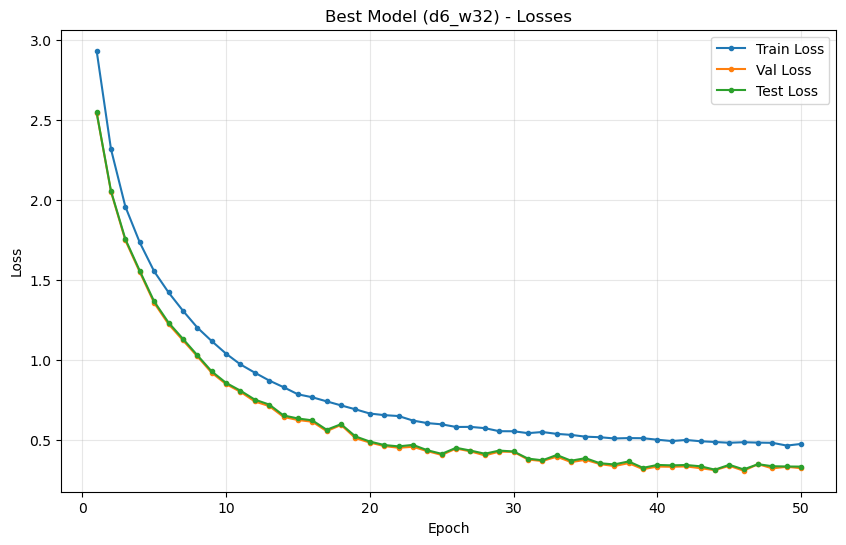

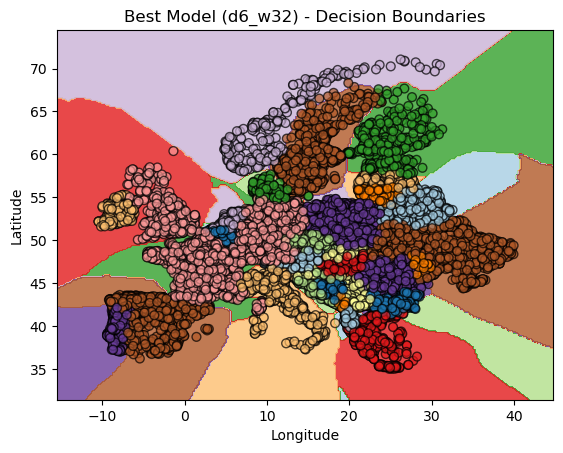

In [30]:
q6_2_res.plot_best_model()

we see this model generalised exceedingly well. reaching the lowest loss seen in previous sections. moreover the test and val loss are even lower (see discussion of section 6.1.2.4). we especially note the complex shape of the descision boundaries, showing that the network is sufficiently expressive to capture complex and non linear boundaries.

--- Analysis of Worst Model ---
Configuration: d1_w16
Final Validation Accuracy: 0.5373


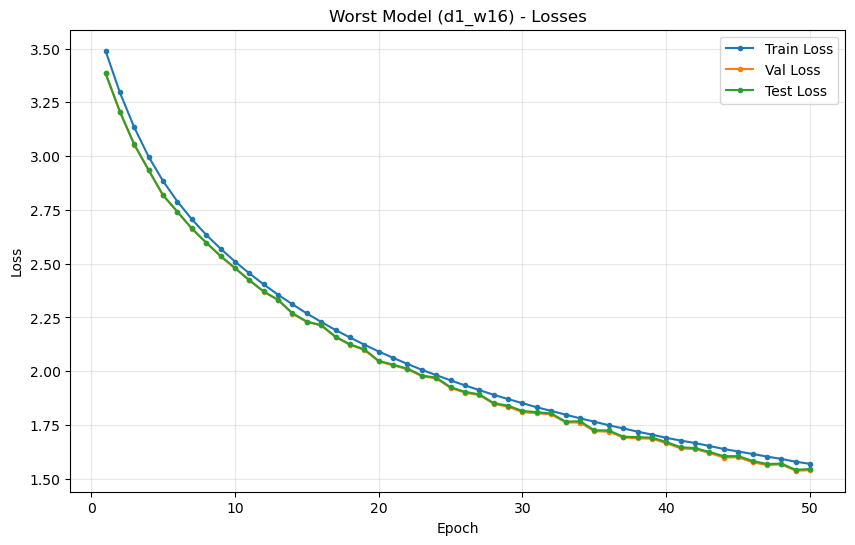

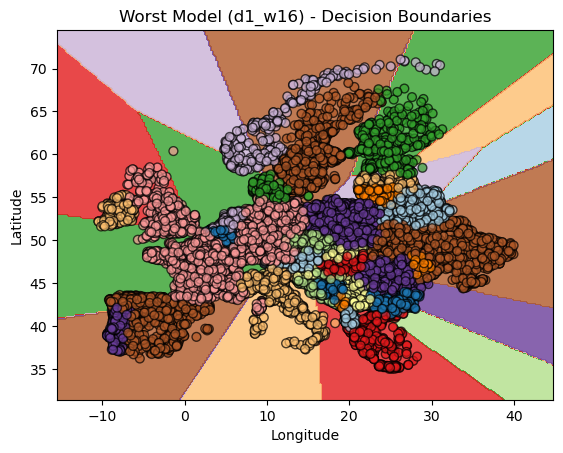

In [31]:
q6_2_res.plot_worst_model()

In [40]:
worst_model = exp_6_2.get_ranked_models()[-1][1].model.model
worst_model

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=16, out_features=33, bias=True)
)

in contrast, the shallow model underfit the data, acheiving a loss of only 1.75 on both train and test sets. we see that the decision boundaries are coarse and straight, indicating the model runs out of epxressive capacity. indeed, this is similar to our discussion of epxressivity of trees, under the understanding that each neuron devides space with a hyper plane.

according to Montúfar et al. and Serra et al. the upper bound on the number of linear regions $R_{max}$ of a ReLU network with input dimension \(n_0\) and a single hidden layer of width \(n_1\) can be written as

$R_{max} \;\le\; \sum_{k=0}^{\min(n_0,\,n_1)} \binom{n_1}{k}$

where $\binom{n_1}{k}$ are binomial coefficients that count the number of regions a set of $n_1$ hyperplanes can define in $\mathbb{R}^{n_0}$ — this is a standard combinatorial upper bound on the number of piecewise-linear regions of a ReLU network.

for the given model with $n_0=2$ and one hidden ReLU layer of width $n_1=16$, this translates to

$R_{max} \;\le\; \binom{16}{0} + \binom{16}{1} + \binom{16}{2} = 1 + 16 + 120 = \boxed{137}$

so the network can partition the 2-dimensional input space into at most **~137 linear regions** in the theoretical worst case.


https://proceedings.neurips.cc/paper_files/paper/2014/file/fa6f2a469cc4d61a92d96e74617c3d2a-Paper.pdf  
https://openreview.net/forum?id=Sy-tszZRZ


#### 6.2.2 effect of depth

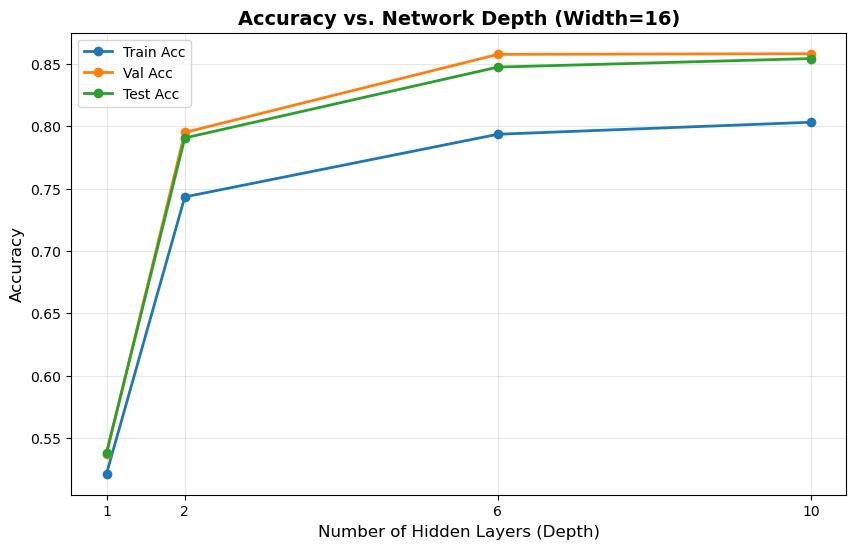

In [28]:
# Q6.2.3: Depth Analysis
q6_2_res.plot_depth_analysis()

in our case we  seen an increase in the accuarcay as the number of layers increases. on the one hand, further layers increase the models epxressive capacity. allowing it to avoid underfitting. the corallary is that it also enables it to overfit, although that doens't seem to have happened here. moreover, had we tested netwroks with tens of layers, we may reach thedepth  limit of vanilla neural network where additional layers do not provide further benefit dues to vanishing/exploding  gradiants. it's possible that the diminishing returns from adding layers 7-10 is a precursor of this phenomenom. 

#### effect of width

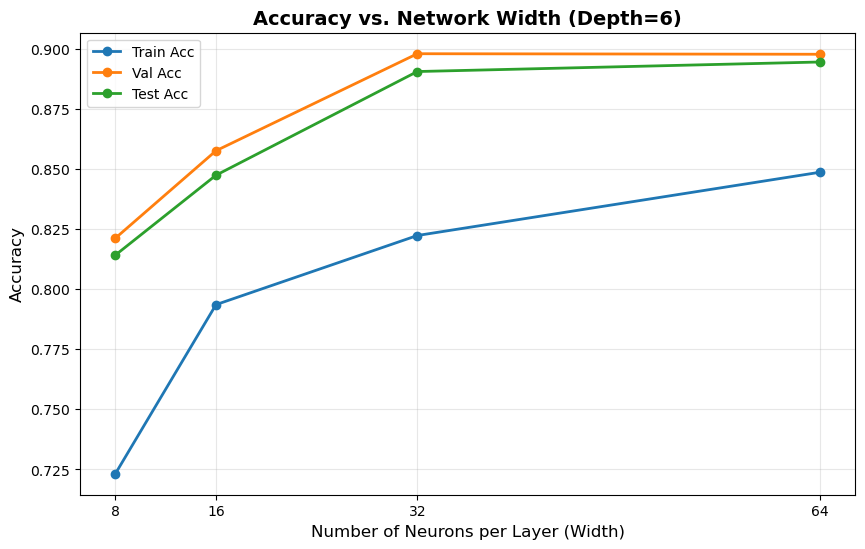

In [29]:
# Q6.2.4: Width Analysis
q6_2_res.plot_width_analysis()

interestingly, increasing the width leads to better results in our case. perhaps since increasing the width increases the epxressivity of the network (although not as drastically as incresing the depth), and avoids the downside of vanishing / exploding gradiants. 

#### exploding grads

--- Starting Gradient Monitoring Experiment (Depth: 100) ---


Training complete.


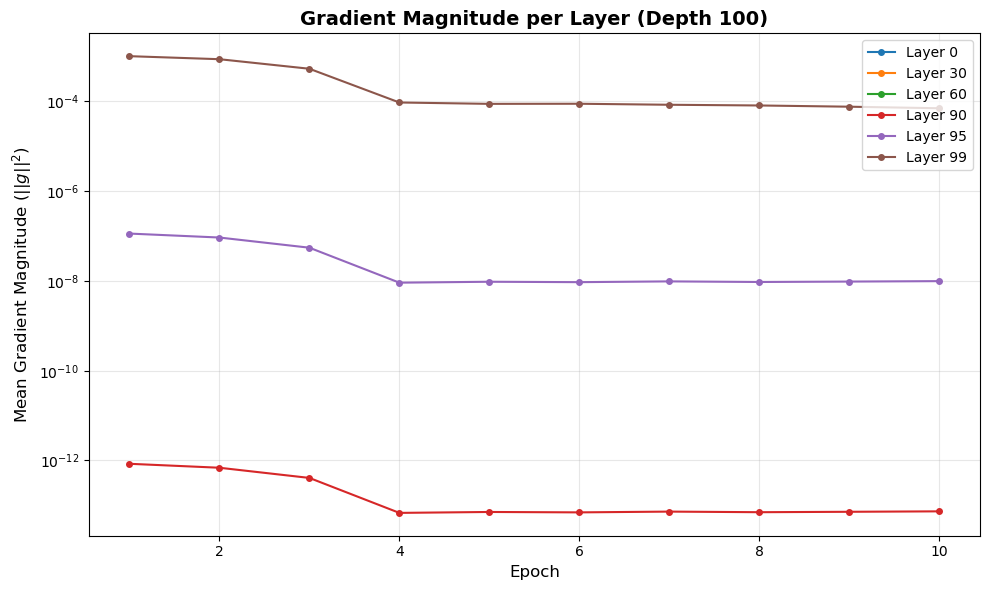

In [43]:
grads_exp = Q6_2_5_Experiment()
grads_exp.run()
grads_plots = Q6_2_5_Results(grads_exp)
grads_plots.plot()

In [45]:
grads_exp.trainer.history['grad_norms'][60]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

we see that indeed, already after 10 layers, the gradaints are tiny (1e-13), and that by layer 60 they are 0 (smaller than machine precision). a solution might be to add residual connections between the layers, since it sets a **lower bound** on the norm of the gradiants at 1.

# RESNET

In [ ]:
# Section 7: CNN Imports
from PIL import Image
from torchvision import transforms, models
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import glob

In [ ]:
class FaceDataset(Dataset):
    """
    Dataset for whichfaceisreal deepfake detection.

    Args:
        root: path to dataset folder (default: 'whichfaceisreal')
        split: 'train', 'val', or 'test'
        mode: 'cnn' (returns tensors) or 'flat' (returns flattened numpy arrays for XGBoost)
        pretrained: if True, use ImageNet normalization; if False, use [0.5, 0.5, 0.5] centering
    """
    def __init__(self, root='whichfaceisreal', split='train', mode='cnn', pretrained=True):
        self.root = root
        self.split = split
        self.mode = mode
        self.pretrained = pretrained

        # Build file list and labels
        # Structure: root/split/0_real/*.jpeg, root/split/1_fake/*.jpeg
        split_dir = os.path.join(root, split)

        self.samples = []  # List of (path, label)

        # Real images: label = 1 (folder: 0_real)
        real_dir = os.path.join(split_dir, '0_real')
        if os.path.exists(real_dir):
            for img_path in glob.glob(os.path.join(real_dir, '*.jpg')):
                self.samples.append((img_path, 1))
            for img_path in glob.glob(os.path.join(real_dir, '*.jpeg')):
                self.samples.append((img_path, 1))
            for img_path in glob.glob(os.path.join(real_dir, '*.png')):
                self.samples.append((img_path, 1))

        # Fake images: label = 0 (folder: 1_fake)
        fake_dir = os.path.join(split_dir, '1_fake')
        if os.path.exists(fake_dir):
            for img_path in glob.glob(os.path.join(fake_dir, '*.jpg')):
                self.samples.append((img_path, 0))
            for img_path in glob.glob(os.path.join(fake_dir, '*.jpeg')):
                self.samples.append((img_path, 0))
            for img_path in glob.glob(os.path.join(fake_dir, '*.png')):
                self.samples.append((img_path, 0))

        # Define transforms based on mode and pretrained
        if mode == 'cnn':
            if pretrained:
                # ImageNet normalization
                self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
                ])
            else:
                # Simple centering for training from scratch
                self.transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                         std=[0.5, 0.5, 0.5])
                ])
        else:
            # mode == 'flat' for XGBoost
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]

        # Load image
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)

        if self.mode == 'flat':
            # Flatten and convert to numpy for XGBoost
            img = img.numpy().flatten()
            return img, label
        else:
            # Return tensor for CNN
            return img, torch.tensor(label, dtype=torch.float32)

    def get_all_data(self):
        """
        Returns all data as numpy arrays. Useful for XGBoost.
        """
        X = []
        y = []
        for i in range(len(self)):
            xi, yi = self[i]
            X.append(xi)
            y.append(yi)
        return np.array(X), np.array(y)

In [ ]:
# Quick test
_test_ds = FaceDataset(split='train', mode='cnn', pretrained=True)
print(f"Train dataset size: {len(_test_ds)}")
if len(_test_ds) > 0:
    _img, _label = _test_ds[0]
    print(f"Image shape: {_img.shape}, Label: {_label}")
del _test_ds

In [ ]:
class ResNetBase(nn.Module):
    """
    Base class for ResNet18-based binary classifiers.
    Subclasses define whether weights are pretrained and which params are trainable.
    """
    def __init__(self):
        super().__init__()
        self.backbone = None  # ResNet18 without final FC
        self.head = None      # Final linear layer (512 -> 1)

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features).squeeze(-1)  # Output shape: (batch,)

    def get_features(self, x):
        """Extract features before head - useful for sklearn probing"""
        return self.backbone(x)


class ResNetScratch(ResNetBase):
    """ResNet18 trained from scratch (random init, all params trainable)"""
    def __init__(self):
        super().__init__()
        # Load ResNet18 without pretrained weights
        resnet = models.resnet18(weights=None)

        # Remove final FC layer, keep everything else
        self.backbone = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten())

        # Binary classification head
        self.head = nn.Linear(512, 1)


class ResNetLinearProbe(ResNetBase):
    """ResNet18 with frozen pretrained backbone, only head is trainable"""
    def __init__(self):
        super().__init__()
        # Load ResNet18 with ImageNet pretrained weights
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Remove final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten())

        # Freeze backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Binary classification head (only trainable part)
        self.head = nn.Linear(512, 1)


class ResNetFineTune(ResNetBase):
    """ResNet18 with pretrained backbone, all params trainable"""
    def __init__(self):
        super().__init__()
        # Load ResNet18 with ImageNet pretrained weights
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Remove final FC layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1], nn.Flatten())

        # Binary classification head
        self.head = nn.Linear(512, 1)

In [ ]:
# Quick test
_scratch = ResNetScratch()
_probe = ResNetLinearProbe()
_finetune = ResNetFineTune()
print(f"Scratch trainable params: {sum(p.numel() for p in _scratch.parameters() if p.requires_grad)}")
print(f"LinearProbe trainable params: {sum(p.numel() for p in _probe.parameters() if p.requires_grad)}")
print(f"FineTune trainable params: {sum(p.numel() for p in _finetune.parameters() if p.requires_grad)}")
del _scratch, _probe, _finetune

In [ ]:
class CNNTrainer:
    """
    PyTorch trainer for binary classification with ResNet variants.
    Uses BCEWithLogitsLoss and Adam optimizer.
    """
    def __init__(self, model, train_loader, val_loader, test_loader,
                 learning_rate=1e-3, num_epochs=1, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.num_epochs = num_epochs

        # Only optimize parameters that require gradients
        self.optimizer = optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=learning_rate
        )
        self.criterion = nn.BCEWithLogitsLoss()

        self.history = {
            'train_loss': [], 'val_loss': [], 'test_loss': [],
            'train_acc': [], 'val_acc': [], 'test_acc': []
        }
        self.is_trained = False

    def train(self):
        for epoch in tqdm(range(self.num_epochs), desc="Epochs", leave=False):
            # Training phase
            self.model.train()
            train_loss = 0.0
            correct = 0
            total = 0

            for X, y in tqdm(self.train_loader, desc="Training", leave=False):
                X, y = X.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(X)
                loss = self.criterion(outputs, y)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * X.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += y.size(0)
                correct += (predicted == y).sum().item()

            avg_train_loss = train_loss / total
            train_acc = correct / total

            # Evaluation phase
            val_loss, val_acc = self.evaluate(self.val_loader)
            test_loss, test_acc = self.evaluate(self.test_loader)

            # Update history
            self.history['train_loss'].append(avg_train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['test_loss'].append(test_loss)
            self.history['test_acc'].append(test_acc)

        self.is_trained = True

    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(self.device), y.to(self.device)
                outputs = self.model(X)
                loss = self.criterion(outputs, y)

                total_loss += loss.item() * X.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += y.size(0)
                correct += (predicted == y).sum().item()

        if total == 0:
            return 0.0, 0.0
        return total_loss / total, correct / total

    def predict(self, loader):
        """Returns predictions and true labels for a loader"""
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for X, y in loader:
                X = X.to(self.device)
                outputs = self.model(X)
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).float()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.numpy())
                all_probs.extend(probs.cpu().numpy())

        return np.array(all_preds), np.array(all_labels), np.array(all_probs)

In [ ]:
class XGBBaseline:
    """
    XGBoost baseline for binary classification.
    Takes flattened image arrays directly.
    """
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

        self.model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        self.is_trained = False

        self.history = {
            'train_acc': None, 'val_acc': None, 'test_acc': None
        }

    def train(self):
        print("Training XGBoost...")
        self.model.fit(self.X_train, self.y_train)

        # Compute accuracies
        self.history['train_acc'] = self.model.score(self.X_train, self.y_train)
        self.history['val_acc'] = self.model.score(self.X_val, self.y_val)
        self.history['test_acc'] = self.model.score(self.X_test, self.y_test)

        self.is_trained = True
        print(f"XGB trained. Test acc: {self.history['test_acc']:.4f}")

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1]

In [ ]:
class BaseExperiment:
    """
    Base class for CNN experiments with learning rate grid search.
    Subclasses define model creation and normalization mode.
    """
    def __init__(self, learning_rates=None, num_epochs=1, batch_size=32, seed=42):
        if learning_rates is None:
            self.learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        else:
            self.learning_rates = learning_rates

        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.seed = seed

        self.trainers = {}  # key: f"lr={lr}"
        self.is_trained = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def _create_model(self):
        """Override in subclass"""
        raise NotImplementedError

    def _uses_pretrained(self):
        """Override in subclass - controls dataset normalization"""
        raise NotImplementedError

    def _get_name(self):
        """Override in subclass - returns experiment name"""
        raise NotImplementedError

    def run(self):
        print(f"--- Running {self._get_name()} Experiment ---")

        # Create data loaders with appropriate normalization
        pretrained = self._uses_pretrained()

        train_ds = FaceDataset(split='train', mode='cnn', pretrained=pretrained)
        val_ds = FaceDataset(split='val', mode='cnn', pretrained=pretrained)
        test_ds = FaceDataset(split='test', mode='cnn', pretrained=pretrained)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_ds, batch_size=self.batch_size, shuffle=False)

        for lr in self.learning_rates:
            print(f"  Training with LR={lr}...")
            set_seed(self.seed)

            model = self._create_model()
            trainer = CNNTrainer(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                learning_rate=lr,
                num_epochs=self.num_epochs,
                device=self.device
            )

            trainer.train()
            self.trainers[f"lr={lr}"] = trainer

            print(f"    -> Test acc: {trainer.history['test_acc'][-1]:.4f}")

        self.is_trained = True
        print(f"{self._get_name()} complete.\n")

    def get_ranked_models(self):
        """Returns list of (key, trainer, test_acc) sorted by test_acc descending"""
        ranking = []
        for key, trainer in self.trainers.items():
            test_acc = trainer.history['test_acc'][-1]
            ranking.append((key, trainer, test_acc))
        ranking.sort(key=lambda x: x[2], reverse=True)
        return ranking

    def get_best_n(self, n=2):
        """Returns top n models by test accuracy"""
        return self.get_ranked_models()[:n]


class ScratchExperiment(BaseExperiment):
    """ResNet18 trained from scratch"""
    def _create_model(self):
        return ResNetScratch()

    def _uses_pretrained(self):
        return False

    def _get_name(self):
        return "ResNet Scratch"


class LinearProbeExperiment(BaseExperiment):
    """Frozen pretrained ResNet18 with trainable head only"""
    def _create_model(self):
        return ResNetLinearProbe()

    def _uses_pretrained(self):
        return True

    def _get_name(self):
        return "Linear Probe"


class FineTuneExperiment(BaseExperiment):
    """Pretrained ResNet18 with all params trainable"""
    def _create_model(self):
        return ResNetFineTune()

    def _uses_pretrained(self):
        return True

    def _get_name(self):
        return "Fine-Tune"

In [ ]:
class XGBExperiment:
    """
    Standalone experiment for XGBoost baseline.
    No learning rate grid since XGBoost uses default parameters.
    """
    def __init__(self, seed=42):
        self.seed = seed
        self.baseline = None
        self.is_trained = False

    def run(self):
        print("--- Running XGBoost Experiment ---")
        set_seed(self.seed)

        # Load data in flat mode (no normalization needed, just [0,1] scaling)
        print("  Loading flattened data...")
        train_ds = FaceDataset(split='train', mode='flat')
        val_ds = FaceDataset(split='val', mode='flat')
        test_ds = FaceDataset(split='test', mode='flat')

        X_train, y_train = train_ds.get_all_data()
        X_val, y_val = val_ds.get_all_data()
        X_test, y_test = test_ds.get_all_data()

        print(f"  Train shape: {X_train.shape}, Val shape: {X_val.shape}, Test shape: {X_test.shape}")

        self.baseline = XGBBaseline(X_train, y_train, X_val, y_val, X_test, y_test)
        self.baseline.train()

        self.is_trained = True
        print("XGBoost experiment complete.\n")

    def get_test_accuracy(self):
        if not self.is_trained:
            raise ValueError("Run experiment first")
        return self.baseline.history['test_acc']

    def get_ranked_models(self):
        """Returns single result in same format as BaseExperiment for compatibility"""
        return [("XGBoost", self.baseline, self.baseline.history['test_acc'])]

    def get_best_n(self, n=1):
        """Returns single XGBoost result"""
        return self.get_ranked_models()[:n]

In [ ]:
class Section7Aggregator:
    """
    Aggregates results across all Section 7 experiments.
    Provides cross-baseline ranking and comparison.
    """
    def __init__(self, experiments: dict):
        """
        Args:
            experiments: dict mapping name to experiment, e.g.:
                {
                    'xgb': XGBExperiment,
                    'scratch': ScratchExperiment,
                    'linear_probe': LinearProbeExperiment,
                    'finetune': FineTuneExperiment
                }
        """
        self.experiments = experiments
        self._validate_experiments()

    def _validate_experiments(self):
        for name, exp in self.experiments.items():
            if not exp.is_trained:
                raise ValueError(f"Experiment '{name}' has not been run yet")

    def get_best_per_baseline(self, n=2):
        """
        Returns dict mapping baseline name to list of (key, model/trainer, test_acc).
        For XGBoost, returns single result.
        """
        results = {}
        for name, exp in self.experiments.items():
            if name == 'xgb':
                results[name] = exp.get_best_n(n=1)  # XGB only has one model
            else:
                results[name] = exp.get_best_n(n=n)
        return results

    def get_all_ranked(self):
        """
        Returns flat list of all models ranked by test accuracy.
        Each item: (baseline_name, config_key, model/trainer, test_acc)
        """
        all_results = []
        for name, exp in self.experiments.items():
            for key, model, acc in exp.get_ranked_models():
                all_results.append((name, key, model, acc))

        all_results.sort(key=lambda x: x[3], reverse=True)
        return all_results

    def get_best_overall(self):
        """Returns the single best model across all baselines"""
        return self.get_all_ranked()[0]

    def get_worst_overall(self):
        """Returns the single worst model across all baselines"""
        return self.get_all_ranked()[-1]

In [ ]:
class Section7Results:
    """
    Visualization and analysis for Section 7.
    Answers Q7.6.1 and Q7.6.2.
    """
    def __init__(self, aggregator: Section7Aggregator):
        self.aggregator = aggregator
        # Store test dataset for visualization
        self.test_ds = FaceDataset(split='test', mode='cnn', pretrained=True)
        self.test_loader = DataLoader(self.test_ds, batch_size=32, shuffle=False)

    def print_summary_table(self):
        """
        Q7.6.1: Print table of best 2 per baseline + worst overall.
        """
        print("=" * 70)
        print("SECTION 7 RESULTS: Best 2 Models per Baseline")
        print("=" * 70)

        best_per_baseline = self.aggregator.get_best_per_baseline(n=2)

        for baseline_name, models in best_per_baseline.items():
            print(f"\n{baseline_name.upper()}:")
            for i, (key, model, acc) in enumerate(models, 1):
                print(f"  {i}. {key}: Test Accuracy = {acc:.4f}")

        print("\n" + "-" * 70)
        worst = self.aggregator.get_worst_overall()
        print(f"WORST OVERALL: {worst[0]} / {worst[1]}: Test Accuracy = {worst[3]:.4f}")
        print("=" * 70)

        # Also print full ranking
        print("\n\nFULL RANKING (all models):")
        print("-" * 50)
        for i, (baseline, key, model, acc) in enumerate(self.aggregator.get_all_ranked(), 1):
            print(f"{i:2d}. [{baseline:12s}] {key:15s} -> {acc:.4f}")

    def plot_misclassified_samples(self, n=5):
        """
        Q7.6.2: Show n samples correctly classified by best model
        but misclassified by worst model.
        """
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Get best and worst models
        best = self.aggregator.get_best_overall()
        worst = self.aggregator.get_worst_overall()

        best_name = f"{best[0]}/{best[1]}"
        worst_name = f"{worst[0]}/{worst[1]}"

        print(f"Best model: {best_name} (acc={best[3]:.4f})")
        print(f"Worst model: {worst_name} (acc={worst[3]:.4f})")

        # Get predictions from both models
        best_model = best[2]
        worst_model = worst[2]

        # Handle XGBoost vs CNN models differently
        if best[0] == 'xgb':
            # XGBoost: use flat data
            flat_ds = FaceDataset(split='test', mode='flat')
            X_test, y_test = flat_ds.get_all_data()
            best_preds = best_model.predict(X_test)
        else:
            # CNN: use trainer's predict method
            best_preds, _, _ = best_model.predict(self.test_loader)

        if worst[0] == 'xgb':
            flat_ds = FaceDataset(split='test', mode='flat')
            X_test, y_test = flat_ds.get_all_data()
            worst_preds = worst_model.predict(X_test)
        else:
            worst_preds, _, _ = worst_model.predict(self.test_loader)

        # Get true labels
        true_labels = np.array([self.test_ds.samples[i][1] for i in range(len(self.test_ds))])

        # Find samples: best correct, worst incorrect
        best_correct = (best_preds == true_labels)
        worst_incorrect = (worst_preds != true_labels)
        target_indices = np.where(best_correct & worst_incorrect)[0]

        if len(target_indices) < n:
            print(f"Warning: Only {len(target_indices)} samples match criteria (requested {n})")
            n = len(target_indices)

        if n == 0:
            print("No samples found that are correct by best and incorrect by worst.")
            return

        # Select n samples
        selected_indices = target_indices[:n]

        # Plot
        fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
        if n == 1:
            axes = [axes]

        # Use raw transform for visualization (no normalization)
        viz_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        for ax, idx in zip(axes, selected_indices):
            img_path, true_label = self.test_ds.samples[idx]
            img = Image.open(img_path).convert('RGB')
            img_tensor = viz_transform(img)

            # Convert to displayable format
            img_np = img_tensor.permute(1, 2, 0).numpy()

            ax.imshow(img_np)
            ax.set_title(f"True: {'Real' if true_label == 1 else 'Fake'}\n"
                        f"Best: {'Real' if best_preds[idx] == 1 else 'Fake'} ✓\n"
                        f"Worst: {'Real' if worst_preds[idx] == 1 else 'Fake'} ✗")
            ax.axis('off')

        plt.suptitle(f"Samples: Correct by {best_name}, Wrong by {worst_name}", fontsize=14)
        plt.tight_layout()
        plt.show()

In [ ]:
# Set seed
set_seed(42)

# Run all experiments
xgb_exp = XGBExperiment()
xgb_exp.run()

scratch_exp = ScratchExperiment()
scratch_exp.run()

probe_exp = LinearProbeExperiment()
probe_exp.run()

finetune_exp = FineTuneExperiment()
finetune_exp.run()

In [ ]:
# Create aggregator
aggregator = Section7Aggregator({
    'xgb': xgb_exp,
    'scratch': scratch_exp,
    'linear_probe': probe_exp,
    'finetune': finetune_exp
})

# Create results handler
results = Section7Results(aggregator)

# Q7.6.1: Summary table
results.print_summary_table()

In [ ]:
# Q7.6.2: Visualization
results.plot_misclassified_samples(n=5)